In [ ]:
pip install nltk
pip install TextBlob


In [14]:
import pandas as pd
from nltk.corpus import stopwords
import re
from textblob import TextBlob

def convert_to_float(price):
    return float(price.replace('₹', '').replace(',', ''))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

def preprocess_data(data_file_path):
    df = pd.read_csv(data_file_path)
    df = df.dropna()
    df = df.drop_duplicates()

    df['discounted_price'] = df['discounted_price'].apply(convert_to_float)
    df['actual_price'] = df['actual_price'].apply(convert_to_float)
    df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float)
    df['rating'] = pd.to_numeric(df['rating'].astype(str).str.replace('|', ''), errors='coerce')
    df['rating_count'] = df['rating_count'].str.replace(',', '').astype(int)
    
    df['product_name'] = df['product_name'].apply(clean_text)
    df['about_product'] = df['about_product'].apply(clean_text)
    df['review_content'] = df['review_content'].apply(clean_text)
    df['category_text'] = df['category'].apply(clean_text)
    
    df['category'] = df['category'].apply(lambda x: x.split('|') if pd.notnull(x) else x)
    df['sentiment'] = df['review_content'].apply(analyze_sentiment)

    return df

filepath = 'amazon.csv'

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder


def feature_engineering(data):
    data['combined_text'] = data['product_name'] + ' ' + data['category_text'] + ' ' + data['about_product'] + ' ' + data['review_content']
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, ngram_range=(1, 1))
    tfidf_matrix = vectorizer.fit_transform(data['combined_text'])

    label_encoder = LabelEncoder()
    data['encoded_sentiment'] = label_encoder.fit_transform(data['sentiment'])

    cosine_sim = cosine_similarity(tfidf_matrix)
    product_user_matrix = data.pivot_table(index='product_id', values='rating', aggfunc='mean').fillna(data['rating'].mean())

    return cosine_sim, product_user_matrix

def hybrid_recommendation(data, product_id, top_n=10):
    idx = data.index[data['product_id'] == product_id][0]

    print(idx)
    cosine_sim, product_user_matrix = feature_engineering(data)

    # Content-based filtering
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    content_recommendations_idx = [i[0] for i in sim_scores[1:top_n+1]]

    # Collaborative Filtering
    if product_id in product_user_matrix.index:
        current_product_rating = product_user_matrix.loc[product_id].values[0]
        similar_rating_products = product_user_matrix.iloc[(product_user_matrix['rating']-current_product_rating).abs().argsort()[:top_n]]

        # Combine recommendations
        collaborative_recommendations_idx = similar_rating_products.index
        collaborative_recommendations_idx = [data.index[data['product_id'] == pid].tolist()[0] for pid in collaborative_recommendations_idx]
        combined_indices = list(set(content_recommendations_idx + collaborative_recommendations_idx))

        recommended_products = data.iloc[combined_indices].copy()
        recommended_products = recommended_products[['product_id', 'product_name', 'rating']]

        return recommended_products

In [16]:
df = preprocess_data(filepath)
df

/var/folders/8t/0s8mc2ln0ts17wldlqdv9j8w0000gn/T/ipykernel_1631/1552665667.py:33: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['rating'] = pd.to_numeric(df['rating'].astype(str).str.replace('|', ''), errors='coerce')


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link,category_text,sentiment
0,B07JW9H4J1,wayona nylon braided usb lightning fast chargi...,"[Computers&Accessories, Accessories&Peripheral...",399.0,1099.0,64.0,4.2,24269,high compatibility compatible iphone 12 11 x x...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",looks durable charging fine toono complains ch...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,computers accessories accessories peripherals ...,Positive
1,B098NS6PVG,ambrane unbreakable 60w 3a fast charging 1 5m ...,"[Computers&Accessories, Accessories&Peripheral...",199.0,349.0,43.0,4.0,43994,compatible type c enabled devices android smar...,"AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",ordered cable connect phone android auto car c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,computers accessories accessories peripherals ...,Positive
2,B096MSW6CT,sounce fast phone charging cable data sync usb...,"[Computers&Accessories, Accessories&Peripheral...",199.0,1899.0,90.0,3.9,7928,fast charger data sync built safety proctectio...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...",quite durable sturdy https media amazon com im...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,computers accessories accessories peripherals ...,Positive
3,B08HDJ86NZ,boat deuce usb 300 2 1 type c micro usb stress...,"[Computers&Accessories, Accessories&Peripheral...",329.0,699.0,53.0,4.2,94363,boat deuce usb 300 2 1 cable compatible smartp...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...",good product long wire charges good nice bough...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,computers accessories accessories peripherals ...,Positive
4,B08CF3B7N1,portronics konnect l 1 2m fast charging 3a 8 p...,"[Computers&Accessories, Accessories&Peripheral...",154.0,399.0,61.0,4.2,16905,charge sync function cable comes charging data...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...",bought instead original apple work 150rs fast ...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,computers accessories accessories peripherals ...,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,noir aqua 5pcs pp spun filter 1 spanner types ...,"[Home&Kitchen, Kitchen&HomeAppliances, WaterPu...",379.0,919.0,59.0,4.0,1090,supreme quality 90 gram 3 layer thik pp spun f...,"AHITFY6AHALOFOHOZEOC6XBP4FEA,AFRABBODZJZQB6Z4U...","Prabha ds,Raghuram bk,Real Deal,Amazon Custome...","R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...",received product without spanner excellent pro...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,home kitchen kitchen homeappliances waterpurif...,Positive
1461,B01M6453MB,prestige delight prwo electric 

In [ ]:

sample_pid = 'B07JW9H4J1'
hybrid_recommendation(df, sample_pid)

In [ ]:
ratings_df = df[['user_id', 'user_name', 'review_id', 'review_title', 'review_content']]

ratings_df['review_content'][0]

In [ ]:
ratings_df

In [ ]:
df.pivot_table(index='product_id', values='rating', aggfunc='mean').fillna(df['rating'].mean())

In [17]:
products = df.drop(columns=['user_id', 'user_name', 'review_id', 'review_title'])
products['combined_text'] = products['product_name'] + ' ' + products['category_text'] + ' ' + products['about_product'] + ' ' + products['review_content']
products

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text
0,B07JW9H4J1,wayona nylon braided usb lightning fast chargi...,"[Computers&Accessories, Accessories&Peripheral...",399.0,1099.0,64.0,4.2,24269,high compatibility compatible iphone 12 11 x x...,looks durable charging fine toono complains ch...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,computers accessories accessories peripherals ...,Positive,wayona nylon braided usb lightning fast chargi...
1,B098NS6PVG,ambrane unbreakable 60w 3a fast charging 1 5m ...,"[Computers&Accessories, Accessories&Peripheral...",199.0,349.0,43.0,4.0,43994,compatible type c enabled devices android smar...,ordered cable connect phone android auto car c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,computers accessories accessories peripherals ...,Positive,ambrane unbreakable 60w 3a fast charging 1 5m ...
2,B096MSW6CT,sounce fast phone charging cable data sync usb...,"[Computers&Accessories, Accessories&Peripheral...",199.0,1899.0,90.0,3.9,7928,fast charger data sync built safety proctectio...,quite durable sturdy https media amazon com im...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,computers accessories accessories peripherals ...,Positive,sounce fast phone charging cable data sync usb...
3,B08HDJ86NZ,boat deuce usb 300 2 1 type c micro usb stress...,"[Computers&Accessories, Accessories&Peripheral...",329.0,699.0,53.0,4.2,94363,boat deuce usb 300 2 1 cable compatible smartp...,good product long wire charges good nice bough...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,computers accessories accessories peripherals ...,Positive,boat deuce usb 300 2 1 type c micro usb stress...
4,B08CF3B7N1,portronics konnect l 1 2m fast charging 3a 8 p...,"[Computers&Accessories, Accessories&Peripheral...",154.0,399.0,61.0,4.2,16905,charge sync function cable comes charging data...,bought instead original apple work 150rs fast ...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,computers accessories accessories peripherals ...,Positive,portronics konnect l 1 2m fast charging 3a 8 p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,noir aqua 5pcs pp spun filter 1 spanner types ...,"[Home&Kitchen, Kitchen&HomeAppliances, WaterPu...",379.0,919.0,59.0,4.0,1090,supreme quality 90 gram 3 layer thik pp spun f...,received product without spanner excellent pro...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,home kitchen kitchen homeappliances waterpurif...,Positive,noir aqua 5pcs pp spun filter 1 spanner types ...
1461,B01M6453MB,prestige delight prwo electric rice cooker 1 l...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",2280.0,3045.0,25.0,4.1,4118,230 volts 400 watts 1 year,ok got everything mentioned measuring cup brok...,https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...,home kitchen kitchen homeappliances smallkitch...,Positive,prestige delight prwo electric rice cooker 1 l...
1462,B009P2LIL4,bajaj majesty rx10 2000 watts heat convector r...,"[Home&Kitchen, Heating,Cooling&AirQuality, Roo...",2219.0,3080.0,28.0,3.6,468,international design styling two heat settings...,plastic cool body u find sturdy surface put ve...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...,home kitchen heating cooling airquality roomhe...,Positive,bajaj majesty rx10 2000 watts heat convector r...
1463,B00J5DYCCA,havells ventil air dsp 230mm exhaust fan pista...,"[Home&Kitchen, Heating,Cooling&AirQuality, Fan...",1399.0,1890.0,26.0,4.0,8031,fa

In [ ]:
products.to_dict('records')

In [18]:
most_popular = products.sort_values('rating_count', ascending=False)
most_popular[:10]

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text
12,B07KSMBL2H,amazonbasics flexible premium hdmi cable black...,"[Electronics, HomeTheater,TV&Video, Accessorie...",219.0,700.0,69.0,4.4,426973,flexible lightweight hdmi cable connecting med...,using 14 days experience pretty good picture q...,https://m.media-amazon.com/images/I/41nPYaWA+M...,https://www.amazon.in/AmazonBasics-Flexible-HD...,electronics hometheater tv video accessories c...,Positive,amazonbasics flexible premium hdmi cable black...
65,B014I8SX4Y,amazon basics high speed hdmi cable 6 feet 2 p...,"[Electronics, HomeTheater,TV&Video, Accessorie...",309.0,1400.0,78.0,4.4,426973,hdmi male male cable supports ethernet 3d 4k v...,using 14 days experience pretty good picture q...,https://m.media-amazon.com/images/I/41eJqkFjCR...,https://www.amazon.in/AmazonBasics-High-Speed-...,electronics hometheater tv video accessories c...,Positive,amazon basics high speed hdmi cable 6 feet 2 p...
47,B014I8SSD0,amazon basics high speed hdmi cable 6 feet sup...,"[Electronics, HomeTheater,TV&Video, Accessorie...",309.0,475.0,35.0,4.4,426973,please select appropriate display resolution r...,using 14 days experience pretty good picture q...,https://m.media-amazon.com/images/I/41bCxnHksn...,https://www.amazon.in/AmazonBasics-High-Speed-...,electronics hometheater tv video accessories c...,Positive,amazon basics high speed hdmi cable 6 feet sup...
684,B07KSMBL2H,amazonbasics flexible premium hdmi cable black...,"[Electronics, HomeTheater,TV&Video, Accessorie...",219.0,700.0,69.0,4.4,426972,flexible lightweight hdmi cable connecting med...,using 14 days experience pretty good picture q...,https://m.media-amazon.com/images/I/41nPYaWA+M...,https://www.amazon.in/AmazonBasics-Flexible-HD...,electronics hometheater tv video accessories c...,Positive,amazonbasics flexible premium hdmi cable black...
400,B07GQD4K6L,boat bassheads 100 ear wired earphones mic fur...,"[Electronics, Headphones,Earbuds&Accessories, ...",379.0,999.0,62.0,4.1,363713,perfect way add style stand crowd boat basshea...,sound quality earphone really good bass part a...,https://m.media-amazon.com/images/I/31qVddHyy5...,https://www.amazon.in/Boat-BassHeads-100-Inspi...,electronics headphones earbuds accessories hea...,Positive,boat bassheads 100 ear wired earphones mic fur...
352,B07GPXXNNG,boat bassheads 100 ear wired earphones mic taf...,"[Electronics, Headphones,Earbuds&Accessories, ...",349.0,999.0,65.0,4.1,363713,perfect way add style stand crowd boat basshea...,sound quality earphone really good bass part a...,https://m.media-amazon.com/images/I/31J6I7SrLX...,https://www.amazon.in/Boat-BassHeads-100-Inspi...,electronics headphones earbuds accessories hea...,Positive,boat bassheads 100 ear wired earphones mic taf...
584,B071Z8M4KX,boat bassheads 100 ear wired headphones mic black,"[Electronics, Headphones,Earbuds&Accessories, ...",365.0,999.0,63.0,4.1,363711,perfect way add style stand crowd boat basshea...,sound quality earphone really good bass part a...,https://m.media-amazon.com/images/I/31IdiM9ZM8...,https://www.amazon.in/boAt-BassHeads-100-Headp...,electronics headphones earbuds accessories hea...,Positive,boat bassheads 100 ear wired headphones mic bl...
370,B09GFPVD9Y,redmi 9 activ carbon black 4gb ram 64gb storag...,"[Electronics, Mobiles&Accessories, Smartphones...",8499.0,10999.0,23.0,4.1,313836,processor octa core helio g35 upto 2 3ghz cloc...,want smart phone use calling using social medi...,https://m.media-amazon.com/images/I/416SpYgTVY...,https://www.amazon.in/Redmi-Activ-Carbon-Black...,electronics mobiles accessories smartphones ba...,Positive,redmi 9 activ carbon black 4gb ram 64gb storag...
371,B09GFLXVH9,redmi 9a sport coral green 2gb ram 32gb storag...,"[Electronics, Mobiles&Accessories, Smartphones...",6499.0,8499.0,24.0,4.1,313836,processor mediatek helio g2

In [19]:
most_popular['category'].drop_duplicates()

12      [Electronics, HomeTheater,TV&Video, Accessorie...
400     [Electronics, Headphones,Earbuds&Accessories, ...
370     [Electronics, Mobiles&Accessories, Smartphones...
1028    [Home&Kitchen, Kitchen&Dining, KitchenTools, M...
588     [Computers&Accessories, ExternalDevices&DataSt...
                              ...                        
863     [Computers&Accessories, Components, InternalHa...
1014    [Computers&Accessories, Laptops, TraditionalLa...
557     [Electronics, Mobiles&Accessories, MobileAcces...
269     [Electronics, HomeAudio, Speakers, TowerSpeakers]
264     [Electronics, HomeAudio, MediaStreamingDevices...
Name: category, Length: 211, dtype: object

In [20]:
most_popular['parent_category'] = most_popular['category'].apply(lambda x: x[0])

In [21]:
most_popular.groupby('parent_category').first()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text
parent_category,,,,,,,,,,,,,,,
Car&Motorbike,B0912WJ87V,reffair ax30 max portable air purifier car hom...,"[Car&Motorbike, CarAccessories, InteriorAccess...",2339.0,4000.0,42.0,3.8,1118,new launch innovative design efficient purific...,working fine expect like dust remove effective...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Reffair-AX30-MAX-Interna...,car motorbike caraccessories interioraccessori...,Positive,reffair ax30 max portable air purifier car hom...
Computers&Accessories,B005FYNT3G,sandisk cruzer blade 32gb usb flash drive,"[Computers&Accessories, ExternalDevices&DataSt...",289.0,650.0,56.0,4.3,253105,ultra compact portable usb flash drive capless...,chip good really happy buy pen drive comparati...,https://m.media-amazon.com/images/I/310mw9KTJv...,https://www.amazon.in/SanDisk-Cruzer-Blade-Fla...,computers accessories externaldevices datastor...,Positive,sandisk cruzer blade 32gb usb flash drive comp...
Electronics,B07KSMBL2H,amazonbasics flexible premium hdmi cable black...,"[Electronics, HomeTheater,TV&Video, Accessorie...",219.0,700.0,69.0,4.4,426973,flexible lightweight hdmi cable connecting med...,using 14 days experience pretty good picture q...,https://m.media-amazon.com/images/I/41nPYaWA+M...,https://www.amazon.in/AmazonBasics-Flexible-HD...,electronics hometheater tv video accessories c...,Positive,amazonbasics flexible premium hdmi cable black...
Health&PersonalCare,B07BKSSDR2,dr trust electronic kitchen digital scale weig...,"[Health&PersonalCare, HomeMedicalSupplies&Equi...",899.0,1900.0,53.0,4.0,3663,tare function comes tare function allows measu...,aesthetically appealing digital kitchen scale ...,https://m.media-amazon.com/images/I/41csvHnDvE...,https://www.amazon.in/Dr-Trust-Electronic-Kitc...,health personalcare homemedicalsupplies equipm...,Positive,dr trust electronic kitchen digital scale weig...
Home&Kitchen,B01LWYDEQ7,pigeon polypropylene mini handy compact choppe...,"[Home&Kitchen, Kitchen&Dining, KitchenTools, M...",199.0,495.0,60.0,4.1,270563,unique string function chop vegetables fruits ...,1st product came faulty got replaced replaceme...,https://m.media-amazon.com/images/I/41cVgYgAKp...,https://www.amazon.in/Pigeon-Stovekraft-Plasti...,home kitchen kitchen dining kitchentools manua...,Positive,pigeon polypropylene mini handy compact choppe...
HomeImprovement,B07R99NBVB,gizga essentials cable organiser cord manageme...,"[HomeImprovement, Electrical, CordManagement]",249.0,599.0,58.0,4.5,5985,gizga essentials reusable cable ties usable lo...,lot cables running soundsystem settop box tv r...,https://m.media-amazon.com/images/I/51llGK9TR+...,https://www.amazon.in/Essentials-Reusable-Doub...,homeimprovement electrical cordmanagement,Positive,gizga essentials cable organiser cord manageme...
MusicalInstruments,B076B8G5D8,boya bym1 auxiliary omnidirectional lavalier c...,"[MusicalInstruments, Microphones, Condenser]",798.0,1995.0,60.0,4.0,68664,boya m1 omni directional microphone perfect vi...,note ready go mic need sound card plugged used...,https://m.media-amazon.com/images/I/41UYenF+ln...,https://www.amazon.in/Boya-Omnidirectional-Lav...,musicalinstruments microphones condenser,Positive,boya bym1 auxiliary omnidirectional lavalier c...
OfficeProducts,B00AXHBBXU,casio fx 82ms 2nd gen non programmable scienti...,"[OfficeProducts, OfficeElectronics, Calculator...",522.0,550.0,5.0,4.4,12179,2nd edition comes features new sleek design cu...,good use solve numericals good excellent tool ...,https://m.media-amazon.com/images/I/41LcHKyVl9...,https://www.amazon.in/Casio-Non-Programmable-S...,officeproducts officeelectronics calculators s...,Positive,casio fx 82ms 2nd gen non programmable scienti...
Toys&Games,B00DJ5N9VK,faber castell connector pen set pack 25 assorted,"[Toys&Games,

In [ ]:
most_popular[:10].to_dict('records')

In [ ]:
df[df['product_id'] == df['product_id'][0]]

In [ ]:
df.index[df['product_id'] == sample_pid][0]

In [ ]:
products

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(products["combined_text"])
X1

<1463x18485 sparse matrix of type '<class 'numpy.float64'>'
	with 224628 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X1.toarray()) 


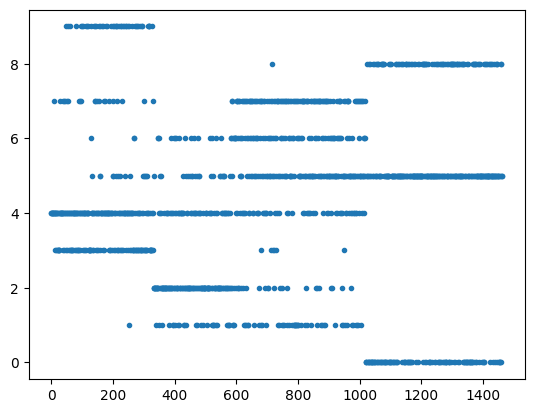

In [44]:
X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [38]:
from sklearn.cluster import KMeans
wcss = [] 

for i in range(1, 15): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(reduced_data) 
    wcss.append(kmeans.inertia_)



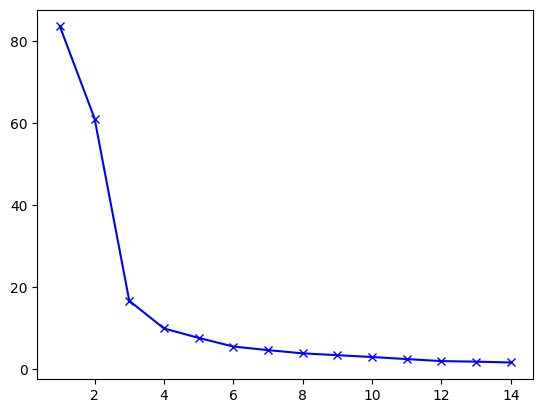

In [39]:
plt.plot(range(1,15), wcss, 'bx-')

In [74]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

In [75]:
true_k = 15

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 fm
 battery
 radio
 speaker
 phone
 mobile
 keypad
 sound
 nokia
 wireless
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
Cluster 2:
 tv
 remote
 hdmi
 picture
 4k
 video
 hd
 good
 smart
 quality
Cluster 3:
 stand
 laptop
 holder
 table
 phone
 tripod
 mobile
 foldable
 good
 selfie
Cluster 4:
 water
 heating
 geyser
 heater
 installation
 filter
 tank
 pressure
 product
 geysers
Cluster 5:
 watch
 smartwatch
 faces
 sports
 calling
 display
 modes
 heart
 battery
 health
Cluster 6:
 ear
 sound
 bass
 headphones
 mic
 earbuds
 earphones
 good
 quality
 noise
Cluster 7:
 coffee
 milk
 frother
 froth
 maker
 filter
 espresso
 easy
 use
 batteries
Cluster 8:
 wifi
 router
 adapter
 speed
 wireless
 fi
 wi
 mbps
 link
 tp
Cluster 9:
 heater
 room
 heating
 fan
 heat
 iron
 product
 good
 kitchen
 irons
Cluster 10:
 mouse
 keyboard
 mice
 dpi
 wireless
 gaming
 keys
 optical
 good
 keyboards
Cluster 11:
 good
 produc

In [92]:
terms[12200]

'orp'

array(['00', '000', '0000', ..., 'zuke', 'zuvexa', 'zyada'], dtype=object)

In [96]:
def show_recommendations(product):
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    print(prediction)
    print_cluster(prediction[0])

    return prediction[0]

In [82]:
show_recommendations("food")


11
Cluster 11:
 good
 product
 kitchen
 easy
 use
 jar
 quality
 lint
 home
 power


In [97]:
products['cluster'] = products['product_name'].apply(show_recommendations)


[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[8]
Cluster 8:
 wifi
 router
 adapter
 speed
 wireless
 fi
 wi
 mbps
 link
 tp
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[1]
Cluster 1:
 cable
 charging
 usb
 cables
 fast
 type
 data
 charge
 accessories
 good
[11]
Cluster 11:
 goo

In [98]:
products['cluster']

0        1
1        1
2        1
3        1
4        1
        ..
1460     4
1461    11
1462     9
1463    11
1464    11
Name: cluster, Length: 1463, dtype: int32

In [99]:
products

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text,cluster
0,B07JW9H4J1,wayona nylon braided usb lightning fast chargi...,"[Computers&Accessories, Accessories&Peripheral...",399.0,1099.0,64.0,4.2,24269,high compatibility compatible iphone 12 11 x x...,looks durable charging fine toono complains ch...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...,computers accessories accessories peripherals ...,Positive,wayona nylon braided usb lightning fast chargi...,1
1,B098NS6PVG,ambrane unbreakable 60w 3a fast charging 1 5m ...,"[Computers&Accessories, Accessories&Peripheral...",199.0,349.0,43.0,4.0,43994,compatible type c enabled devices android smar...,ordered cable connect phone android auto car c...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...,computers accessories accessories peripherals ...,Positive,ambrane unbreakable 60w 3a fast charging 1 5m ...,1
2,B096MSW6CT,sounce fast phone charging cable data sync usb...,"[Computers&Accessories, Accessories&Peripheral...",199.0,1899.0,90.0,3.9,7928,fast charger data sync built safety proctectio...,quite durable sturdy https media amazon com im...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...,computers accessories accessories peripherals ...,Positive,sounce fast phone charging cable data sync usb...,1
3,B08HDJ86NZ,boat deuce usb 300 2 1 type c micro usb stress...,"[Computers&Accessories, Accessories&Peripheral...",329.0,699.0,53.0,4.2,94363,boat deuce usb 300 2 1 cable compatible smartp...,good product long wire charges good nice bough...,https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...,computers accessories accessories peripherals ...,Positive,boat deuce usb 300 2 1 type c micro usb stress...,1
4,B08CF3B7N1,portronics konnect l 1 2m fast charging 3a 8 p...,"[Computers&Accessories, Accessories&Peripheral...",154.0,399.0,61.0,4.2,16905,charge sync function cable comes charging data...,bought instead original apple work 150rs fast ...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...,computers accessories accessories peripherals ...,Positive,portronics konnect l 1 2m fast charging 3a 8 p...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,noir aqua 5pcs pp spun filter 1 spanner types ...,"[Home&Kitchen, Kitchen&HomeAppliances, WaterPu...",379.0,919.0,59.0,4.0,1090,supreme quality 90 gram 3 layer thik pp spun f...,received product without spanner excellent pro...,https://m.media-amazon.com/images/I/41fDdRtjfx...,https://www.amazon.in/Noir-Aqua-Spanner-Purifi...,home kitchen kitchen homeappliances waterpurif...,Positive,noir aqua 5pcs pp spun filter 1 spanner types ...,4
1461,B01M6453MB,prestige delight prwo electric rice cooker 1 l...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",2280.0,3045.0,25.0,4.1,4118,230 volts 400 watts 1 year,ok got everything mentioned measuring cup brok...,https://m.media-amazon.com/images/I/41gzDxk4+k...,https://www.amazon.in/Prestige-Delight-PRWO-1-...,home kitchen kitchen homeappliances smallkitch...,Positive,prestige delight prwo electric rice cooker 1 l...,11
1462,B009P2LIL4,bajaj majesty rx10 2000 watts heat convector r...,"[Home&Kitchen, Heating,Cooling&AirQuality, Roo...",2219.0,3080.0,28.0,3.6,468,international design styling two heat settings...,plastic cool body u find sturdy surface put ve...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Bajaj-RX-10-2000-Watt-Co...,home kitchen heating cooling airquality roomhe...,Positive,bajaj majesty rx10 2000 watts heat convector r...,9
1463,B00J5DYCCA,havells ventil air dsp 230mm exhaust fan pista...,"[Home&Kitchen, Heating,Cooling&AirQuality, Fan...",1

In [102]:
product_in_same_cluster = products[products['cluster'] == 7]
product_in_same_cluster

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text,cluster
1036,B07GXPDLYQ,pro365 indo mocktails coffee foamer cappuccino...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",249.0,499.0,50.0,3.3,8427,get creamy froth quickly higher speed motor mi...,works expected shape handle comfortable feelin...,https://m.media-amazon.com/images/I/31MmLP6awM...,https://www.amazon.in/PRO365-Electric-Coffee-S...,home kitchen kitchen homeappliances smallkitch...,Positive,pro365 indo mocktails coffee foamer cappuccino...,7
1117,B0B4KPCBSH,ikea frother milk,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",244.0,499.0,51.0,3.3,478,batteries sold separately 2aa batteries recomm...,ikea sales product 99 worth quality top notch ...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ikea-45454-IKEA-Frother-...,home kitchen kitchen homeappliances coffee tea...,Positive,ikea frother milk home kitchen kitchen homeapp...,7
1194,B0BPCJM7TB,widewings electric handheld milk wand mixer fr...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",259.0,999.0,74.0,4.0,43,battery operated milk frother easy control eas...,first coffee frother loved made frothing ready...,https://m.media-amazon.com/images/I/41sJ4KQa5x...,https://www.amazon.in/WIDEWINGS-Electric-Handh...,home kitchen kitchen homeappliances smallkitch...,Positive,widewings electric handheld milk wand mixer fr...,7
1201,B0BQ3K23Y1,oratech coffee frother electric milk frother e...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",279.0,499.0,44.0,4.8,28,make delicious milk foam creamer drinks home w...,overall love oratech coffee frother used soooo...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Oratech-electric-cappucc...,home kitchen kitchen homeappliances smallkitch...,Positive,oratech coffee frother electric milk frother e...,7
1223,B0BM4KTNL1,figment handheld milk frother rechargeable 3 s...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",699.0,1599.0,56.0,4.7,1729,rechargeable multi function milk frother milk ...,value money effective claimed average product ...,https://m.media-amazon.com/images/I/51oN+8Zs5Y...,https://www.amazon.in/FIGMENT-Rechargeable-Dec...,home kitchen kitchen homeappliances smallkitch...,Positive,figment handheld milk frother rechargeable 3 s...,7
1226,B0BLC2BYPX,zuvexa usb rechargeable electric foam maker ha...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",499.0,1299.0,62.0,4.7,54,food taste stainless steel whisking head remov...,first time tried send eggs milk cream kitchen ...,https://m.media-amazon.com/images/I/41714O1hnm...,https://www.amazon.in/Zuvexa-Rechargeable-Elec...,home kitchen kitchen homeappliances smallkitch...,Positive,zuvexa usb rechargeable electric foam maker ha...,7
1233,B098T9CJVQ,sui generis electric handheld milk wand mixer ...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",210.0,699.0,70.0,3.7,74,multifunctional portable espresso maker used m...,good little weak end also sometimes starts bat...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sui-Generis-Frother-Elec...,home kitchen kitchen homeappliances smallkitch...,Positive,sui generis electric handheld milk wand mixer ...,7
1270,B09X5HD5T1,ikea little loved corner produkt milk frother ...,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",229.0,499.0,54.0,3.5,185,frothes milk 15 20 seconds used cold hot drink...,good easy use product appears cheap works alri...,https://m.media-amazon.com/images/I/21OPu5-M3q...,https://www.amazon.in/Ikea-PRODUKT-Milk-frothe...,home kitchen kitchen homeappliances coffee tea...,Positive,ikea little loved corner produkt milk frother ...,7
1327,B08CGW4GYR,milk frother immersion blender cordlesss foam ...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",375.0,999.0,62.0,3.6,1988,fast get creamy froth great power immersion bl...,good 

In [103]:
product_in_same_cluster.sort_values('rating_count', ascending=False)

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text,cluster
1036,B07GXPDLYQ,pro365 indo mocktails coffee foamer cappuccino...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",249.0,499.0,50.0,3.3,8427,get creamy froth quickly higher speed motor mi...,works expected shape handle comfortable feelin...,https://m.media-amazon.com/images/I/31MmLP6awM...,https://www.amazon.in/PRO365-Electric-Coffee-S...,home kitchen kitchen homeappliances smallkitch...,Positive,pro365 indo mocktails coffee foamer cappuccino...,7
1329,B0763K5HLQ,instacuppa milk frother coffee handheld batter...,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",1099.0,1499.0,27.0,4.1,4401,battery operated perfect froth time mixer batt...,nice product says thing great speed put dura c...,https://m.media-amazon.com/images/I/41Lfns2oFN...,https://www.amazon.in/InstaCuppa-Handheld-Oper...,home kitchen kitchen homeappliances coffee tea...,Positive,instacuppa milk frother coffee handheld batter...,7
1327,B08CGW4GYR,milk frother immersion blender cordlesss foam ...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",375.0,999.0,62.0,3.6,1988,fast get creamy froth great power immersion bl...,good product received give full review 7days v...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Rechargeable-whisks%EF%B...,home kitchen kitchen homeappliances smallkitch...,Positive,milk frother immersion blender cordlesss foam ...,7
1223,B0BM4KTNL1,figment handheld milk frother rechargeable 3 s...,"[Home&Kitchen, Kitchen&HomeAppliances, SmallKi...",699.0,1599.0,56.0,4.7,1729,rechargeable multi function milk frother milk ...,value money effective claimed average product ...,https://m.media-amazon.com/images/I/51oN+8Zs5Y...,https://www.amazon.in/FIGMENT-Rechargeable-Dec...,home kitchen kitchen homeappliances smallkitch...,Positive,figment handheld milk frother rechargeable 3 s...,7
1368,B08KS2KQTK,pajaka south indian filter coffee maker 200 ml...,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",293.0,499.0,41.0,4.1,1456,strength coffee filter strong durable sufficie...,1 steel quality could better adequate 2 second...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/n1-Retail-Stainless-Indi...,home kitchen kitchen homeappliances coffee tea...,Positive,pajaka south indian filter coffee maker 200 ml...,7
1372,B07F1T31ZZ,raffles premium stainless steel south indian c...,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",249.0,400.0,38.0,4.1,693,crafted stainless steel rust proof ideal makin...,easy use coffee filter reasonable price value ...,https://m.media-amazon.com/images/I/41UGgTLOD4...,https://www.amazon.in/Raffles-Premium-Stainles...,home kitchen kitchen homeappliances coffee tea...,Positive,raffles premium stainless steel south indian c...,7
1369,B095K14P86,saiyam stainless steel espresso maker stovetop...,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",599.0,1299.0,54.0,4.2,590,safe material made high quality food grade sta...,quality coffee maker excellent dm ease making ...,https://m.media-amazon.com/images/I/414gUKUBHM...,https://www.amazon.in/Saiyam-Stainless-Espress...,home kitchen kitchen homeappliances coffee tea...,Positive,saiyam stainless steel espresso maker stovetop...,7
1117,B0B4KPCBSH,ikea frother milk,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",244.0,499.0,51.0,3.3,478,batteries sold separately 2aa batteries recomm...,ikea sales product 99 worth quality top notch ...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ikea-45454-IKEA-Frother-...,home kitchen kitchen homeappliances coffee tea...,Positive,ikea frother milk home kitchen kitchen homeapp...,7
1448,B09LMMFW3S,ikea milk frother milk coffee cold hot drinks ...,"[Home&Kitchen, Kitchen&HomeAppliances, Coffee,...",229.0,399.0,43.0,3.6,451,frothes milk 15 20 seconds used cold hot milk .

In [104]:
products[products['product_id'] == 'B09GFPN6TP']

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_content,img_link,product_link,category_text,sentiment,combined_text,cluster
566,B09GFPN6TP,redmi 9a sport coral green 3gb ram 32gb storag...,"[Electronics, Mobiles&Accessories, Smartphones...",7499.0,9499.0,21.0,4.1,313832,processor mediatek helio g25 octa core 2 0ghz ...,want smart phone use calling using social medi...,https://m.media-amazon.com/images/I/41i7LM0pGw...,https://www.amazon.in/Redmi-9A-Sport-Octa-core...,electronics mobiles accessories smartphones ba...,Positive,redmi 9a sport coral green 3gb ram 32gb storag...,11
